In [30]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt

* sfocus__S_Caption
* sfocus__S_Caption__S_Colors
* sfocus__S_Caption__S_Emotions
* sfocus__S_Caption__S_Luminosity
* sfocus__S_Caption__S_Objects
* sfocus__Subjectmatter

In [31]:
models_name = [
    "sfocus__S_Caption",
    "sfocus__S_Caption__S_Colors",
    "sfocus__S_Caption__S_Emotions",
    "sfocus__S_Caption__S_Luminosity",
    "sfocus__S_Caption__S_Objects",
    "sfocus__Subjectmatter",
]
data = {}
for model_name in models_name:
    data[model_name] = {}
    data[model_name]["metrics"] = pd.read_csv(f"../../benchmarks/multilingual_results_{model_name}.csv")
    data[model_name]["positions"] = json.load(open(f"../../benchmarks/positions_specific_focus_{model_name}.json"))

In [32]:
def getdf(model_name, focus=None):
    if focus is None:
        df = data[model_name]["metrics"] 
    else:
        df = data[model_name]["metrics"][data[model_name]["metrics"]["focus"] == focus]
    df["model_name"] = model_name
    return df

def getjson(model_name, focus):
    if focus is None:
        positions_merged = {}
        for lang in data[model_name]["positions"]:
            positions_merged[lang] = []
            for focus in data[model_name]["positions"][lang]:
                positions_merged[lang].extend(data[model_name]["positions"][lang][focus])
        return positions_merged
    else:
        positions = {}
        for lang in data[model_name]["positions"]:
            positions[lang] = data[model_name]["positions"][lang][focus]
        return positions

def histogram_positions(model_name, focus):
    positions = getjson(model_name, focus)
    langs = list(positions.keys())
    fig, axs = plt.subplots(1, len(langs), figsize=(15, 5))
    for i, lang in enumerate(langs):
        axs[i].hist(positions[lang], bins=20, edgecolor='black')
        axs[i].set_title(lang)
        axs[i].set_xlabel("Position")
        axs[i].set_ylabel("Frequency")
    plt.suptitle(f"Histogram of positions for {model_name} and {focus}")
    plt.tight_layout()
    plt.show()

def cdf_positions(model_name, focus):
    positions = getjson(model_name, focus) 
    langs = list(positions.keys())

    fig, axs = plt.subplots(1, len(langs), figsize=(15, 5))

    if len(langs) == 1:
        axs = [axs]

    # Get overall max position
    max_position = 0
    for lang in langs:
        max_position = max(max_position, max(positions[lang]))

    for i, lang in enumerate(langs):
        data = np.sort(positions[lang])
        cdf = np.arange(1, len(data) + 1) / len(data)
        # Fill cdf with 1 so that the last point is at the max position
        
        while data[-1] < max_position:
            data = np.concatenate([data, [max_position]])
            cdf = np.concatenate([cdf, [1]])

        percentile_90 = np.percentile(data, 90)
        percentile_95 = np.percentile(data, 95)
        percentile_99 = np.percentile(data, 99)

        # Vlines for 90, 95, 99 percentile
        axs[i].vlines(percentile_90, 0, 1, color='r', linestyle='--', label='90th Percentile')
        axs[i].vlines(percentile_95, 0, 1, color='g', linestyle='--', label='95th Percentile')
        axs[i].vlines(percentile_99, 0, 1, color='y', linestyle='--', label='99th Percentile')
        

        axs[i].plot(data, cdf, linestyle='-', color='b', label='CDF')
        axs[i].set_title(lang)
        axs[i].set_xlabel("Position")
        axs[i].set_ylabel("Cumulative Frequency")
        axs[i].grid(True, linestyle='--', alpha=0.5)
        axs[i].set_xlim(0, max_position)
        axs[i].legend(loc='lower right')

    plt.suptitle(f"CDF of positions for {model_name} and {focus}")
    plt.subplots_adjust(top=0.85)
    plt.tight_layout()
    plt.show()

In [33]:
# Add to the metrics the percentile 50, 90, 95, 99
positions_per_model_per_lang = {}
for model_name in models_name:
    positions_per_model_per_lang[model_name] = {}
    print("Done ", model_name)
    for focus in data[model_name]["metrics"]["focus"].unique():
        if focus=="all_focus":
            continue
        df = getdf(model_name, focus)
        json_data = getjson(model_name, focus)
        for lang in json_data.keys():
            positions = json_data[lang]
            # Create a boolean mask for the correct rows
            mask = (df["model_name"] == model_name) & (df["lang"] == lang)
            # Apply the mask to update the percentiles
            df.loc[mask, "percentile_50"] = np.percentile(positions, 50)
            df.loc[mask, "percentile_75"] = np.percentile(positions, 75)
            df.loc[mask, "percentile_90"] = np.percentile(positions, 90)
            df.loc[mask, "percentile_95"] = np.percentile(positions, 95)
            df.loc[mask, "percentile_99"] = np.percentile(positions, 99)

    # Add for all_focus
    df = getdf(model_name, None)
    json_data = getjson(model_name, None)
    for lang in json_data.keys():
        positions = json_data[lang]
        positions_per_model_per_lang[model_name][lang] = positions
        # Create a boolean mask for the correct rows
        mask = (df["model_name"] == model_name) & (df["lang"] == lang)
        # Apply the mask to update the percentiles
        df.loc[mask, "percentile_50"] = np.percentile(positions, 50)
        df.loc[mask, "percentile_75"] = np.percentile(positions, 75)
        df.loc[mask, "percentile_90"] = np.percentile(positions, 90)
        df.loc[mask, "percentile_95"] = np.percentile(positions, 95)
        df.loc[mask, "percentile_99"] = np.percentile(positions, 99)

Done  sfocus__S_Caption
Done  sfocus__S_Caption__S_Colors
Done  sfocus__S_Caption__S_Emotions
Done  sfocus__S_Caption__S_Luminosity
Done  sfocus__S_Caption__S_Objects
Done  sfocus__Subjectmatter


C:\Users\victo\AppData\Local\Temp\ipykernel_1672\4104679395.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["model_name"] = model_name
C:\Users\victo\AppData\Local\Temp\ipykernel_1672\875097596.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, "percentile_50"] = np.percentile(positions, 50)
C:\Users\victo\AppData\Local\Temp\ipykernel_1672\875097596.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

In [34]:
all_focus_df = pd.concat([getdf(model_name, "all_focus") for model_name in models_name])
all_focus_df

C:\Users\victo\AppData\Local\Temp\ipykernel_1672\4104679395.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["model_name"] = model_name


,lang,focus,loss,average_position,mrr,recall@1,recall@5,recall@10,nDCG@1,nDCG@5,nDCG@10,model_name,percentile_50,percentile_75,percentile_90,percentile_95,percentile_99
4,FR,all_focus,0.390076,2.829621,0.729535,0.590945,0.911479,0.968070,0.590945,0.768511,0.787007,sfocus__S_Caption,1.0,3.0,6.0,9.00,33.41
9,EN,all_focus,0.252096,1.951688,0.801004,0.687533,0.948237,0.981722,0.687533,0.833908,0.844896,sfocus__S_Caption,1.0,2.0,4.0,7.00,14.47
14,NL,all_focus,0.682805,4.358755,0.636177,0.486846,0.832880,0.907524,0.486846,0.673756,0.698651,sfocus__S_Caption,2.0,4.0,11.0,21.35,53.47
4,FR,all_focus,0.413012,2.923550,0.740083,0.608090,0.913673,0.964107,0.608090,0.777398,0.794014,sfocus__S_Caption__S_Colors,1.0,3.0,5.7,9.00,37.35
9,EN,all_focus,0.274563,1.956608,0.805272,0.696557,0.944506,0.980290,0.696557,0.835714,0.847609,sfocus__S_Caption__S_Colors,1.0,2.0,4.0,6.00,16.41
14,NL,all_focus,0.724848,4.706343,0.631933,0.480146,0.823641,0.905865,0.480146,0.668259,0.694928,sfocus__S_Caption__S_Colors,2.0,4.0,12.0,22.00,60.41
4,FR,all_focus,0.445446,3.087857,0.719598,0.577937,0.900039,0.939888,0.577937,0.758484,0.771650,sfocus__S_Caption__S_Emotions,1.0,3.0,6.0,13.00,37.94
9,EN,all_focus,0.291528,2.165497,0.800749,0.697112,0.936804,0.977209,0.697112,0.830054,0.843171,sfocus__S_Caption__S_Emotions,1.0,2.0,4.0,7.00,20.47
14,NL,all_focus,0.891794,5.225066,0.598331,0.439404,0.798212,0.896069,0.439404,0.634689,0.666682,sfocus__S_Caption__S_Emotions,2.0,5.0,13.0,25.00,62.29
4,FR,all_focus,0.451503,3.387595,0.732423,0.601262,0.904661,0.951347,0.601262,0.769503,0.784478,sfocus__S_Caption__S_Luminosity,1.0,3.0,6.0,11.00,50.47


In [35]:
if False:
    mean_mrr_per_model = {}
    for model_name in ["basic-base"]:
        mean_mrr_per_model[model_name] = {}
        focuses = data[model_name]["metrics"]["focus"].unique()
        for focus in focuses:
            if focus=="all_focus":
                continue
            df = getdf(model_name, focus)
            mrrs = df["mrr"].values
            mean_mrr = round(float(np.mean(mrrs)), 3)
            mean_mrr_per_model[model_name][focus] = mean_mrr

    mean_mrr_per_model

In [36]:
# 	lang	focus	loss	average_position	mrr	recall@1	recall@5	recall@10	nDCG@1	nDCG@5	nDCG@10	model_name	percentile_50	percentile_75	percentile_90	percentile_95	percentile_99
def get_table_lang(lang):
    table_LANG = pd.DataFrame(all_focus_df[all_focus_df["lang"] == lang])
    # Remove columns
    table_LANG = table_LANG.drop(columns=["loss", "lang", "focus", "nDCG@1", "percentile_99"])
    # Columns for training_data
    table_LANG["training_data"] = [
        "Synthetic captions",
        "Synthetic captions + Synthetic colors",
        "Synthetic captions + Synthetic emotions",
        "Synthetic captions + Synthetic luminosity",
        "Synthetic captions + Synthetic objects",
        "Real subject matter"
    ]
    table_LANG["pretrained_model"] = [
        "L/14",
        "L/14",
        "L/14",
        "L/14",
        "L/14",
        "L/14"
    ]
    # Round specific columns
    round_factor = 3
    numeric_columns = [
        "average_position",
        "mrr",
        "recall@1",
        "recall@5",
        "recall@10",
        "nDCG@5",
        "nDCG@10",
        "percentile_50",
        "percentile_75",
        "percentile_90",
        "percentile_95"
    ]
    for col in numeric_columns:
        table_LANG[col] = table_LANG[col].round(round_factor)
        if col in ["average_position", "percentile_50", "percentile_75", "percentile_90", "percentile_95"]:
            best_value = table_LANG[col].min()
        else:
            best_value = table_LANG[col].max()
        # Bold the value if it is the best in the column
        table_LANG[col] = table_LANG[col].apply(lambda x: f"\\textbf{{{x}}}" if x == best_value else str(x))
    # For each numeric column, bold the value
    # Reorder columns
    table_LANG = table_LANG[["training_data", "pretrained_model", "model_name", "average_position", "mrr", "recall@1", "recall@5", "recall@10", "nDCG@5", "nDCG@10", "percentile_50", "percentile_75", "percentile_90", "percentile_95"]]
    # Rename columns
    table_LANG = table_LANG.rename(columns={
        "training_data": "Dataset",
        "pretrained_model": "ViT",
        "model_name": "Model",
        "average_position": "Avg. Pos.",
        "mrr": "MRR",
        "recall@1": "Recall@1",
        "recall@5": "Recall@5",
        "recall@10": "Recall@10",
        "nDCG@5": "nDCG@5",
        "nDCG@10": "nDCG@10",
        "percentile_50": "P50",
        "percentile_75": "P75",
        "percentile_90": "P90",
        "percentile_95": "P95"
    })
    # drop index
    table_LANG = table_LANG.reset_index(drop=True)
    return table_LANG

table_FR = get_table_lang("FR")
table_EN = get_table_lang("EN")
table_NL = get_table_lang("NL")

In [37]:
# print as latex table
table_FR.to_csv("../../CSV/table_FR_sfocus.csv", index=False)

In [38]:
table_EN.to_csv("../../CSV/table_EN_sfocus.csv", index=False)

In [39]:
table_NL.to_csv("../../CSV/table_NL_sfocus.csv", index=False)

In [40]:
colors = [
    "#fdcb6e", 
    "#e84393", 
    "#d63031", 
    "#0984e3", 
    "#6c5ce7", 

    "#2d3436",
]

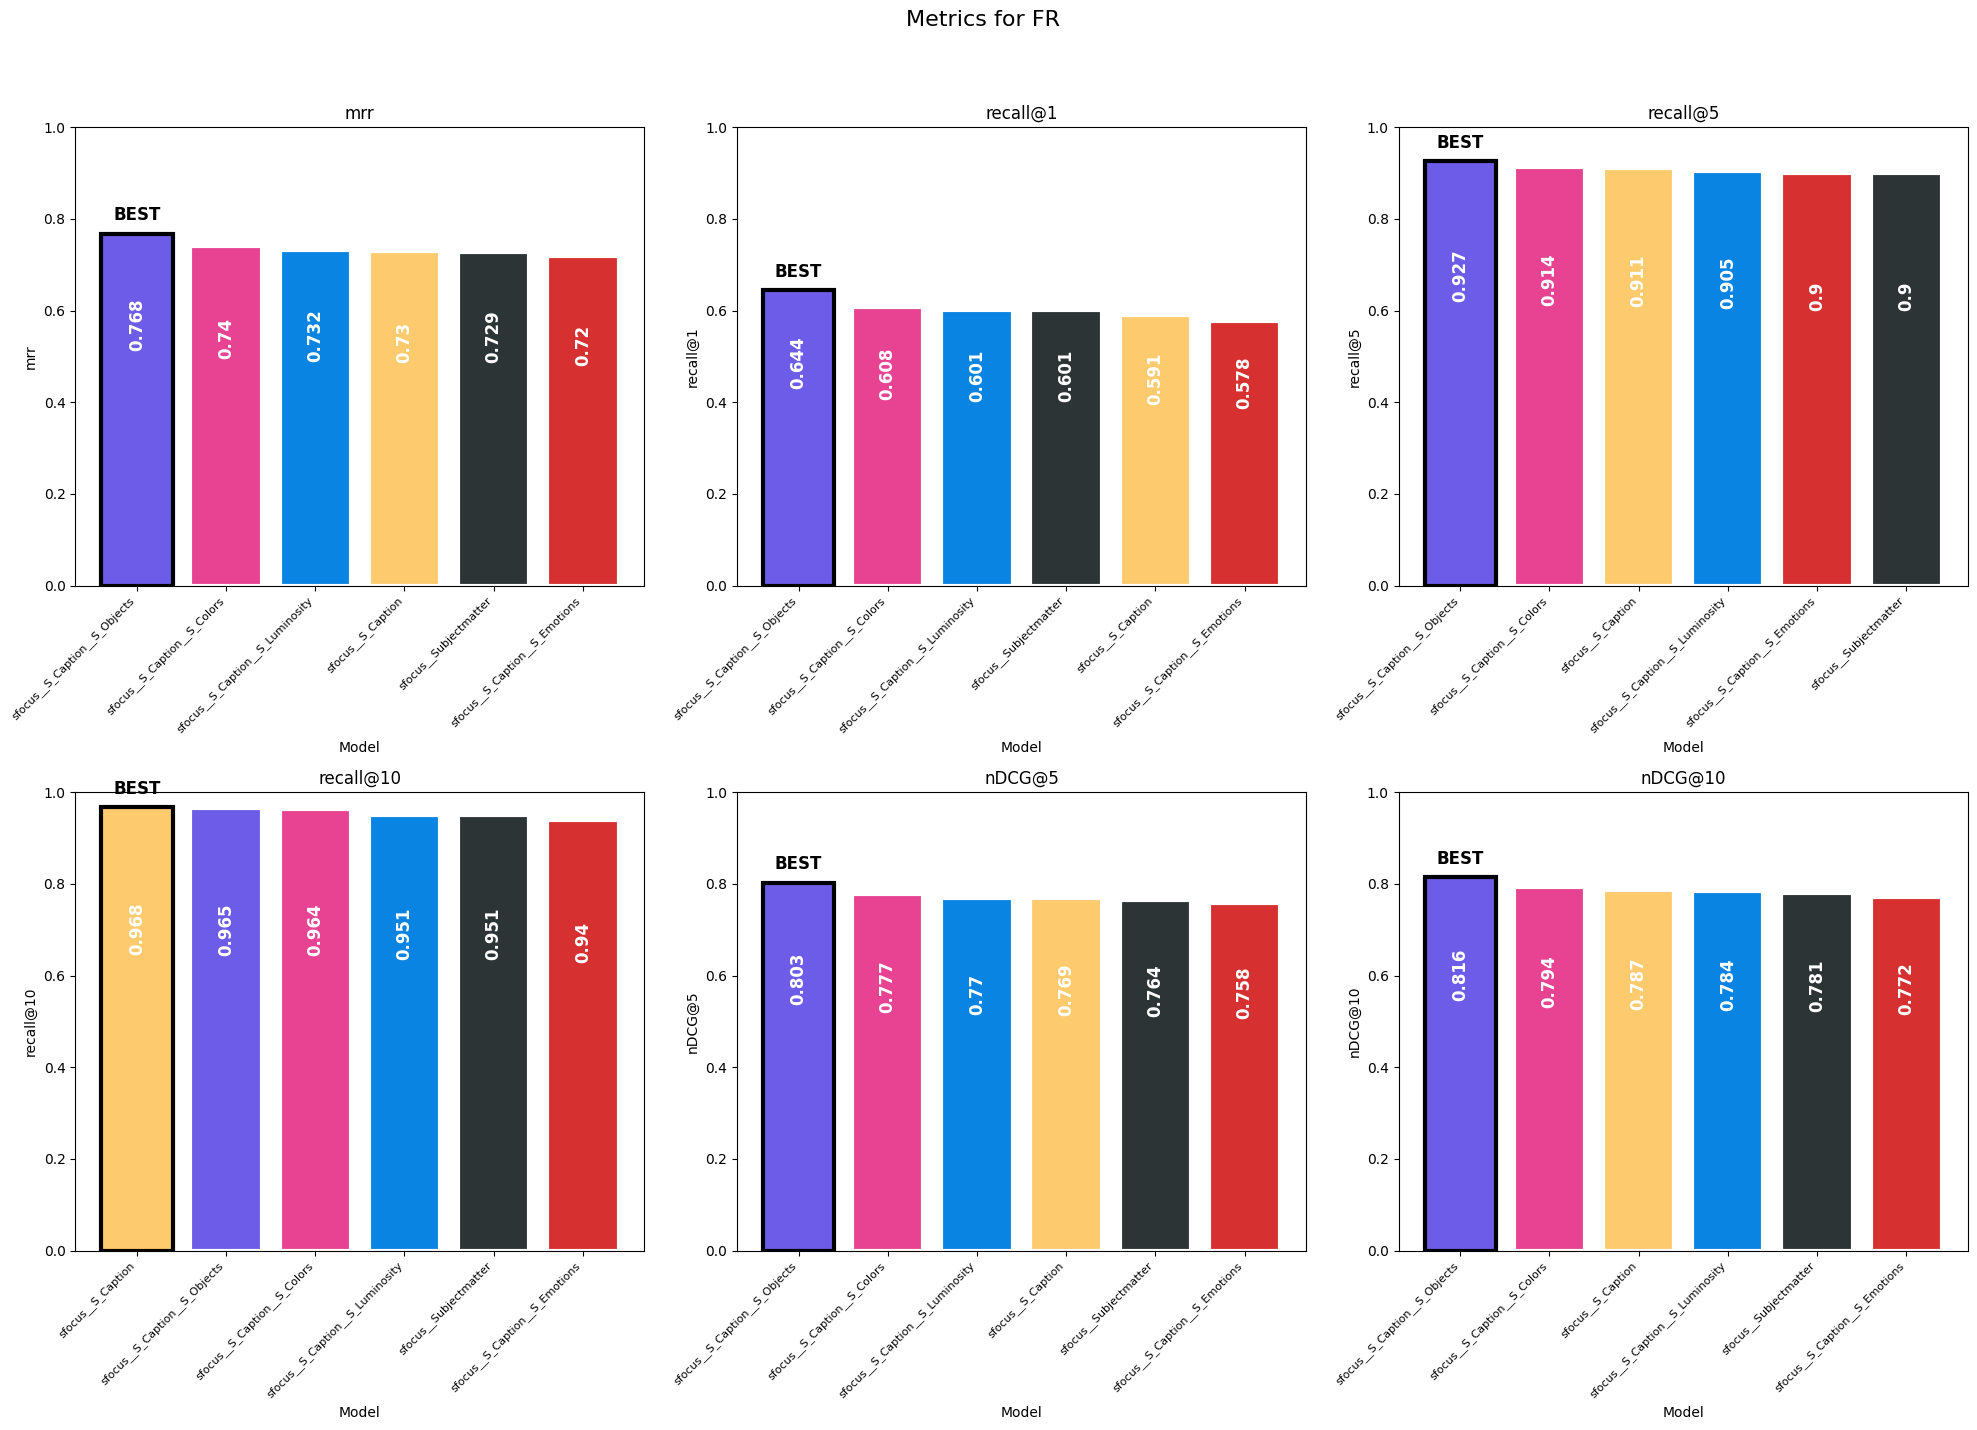

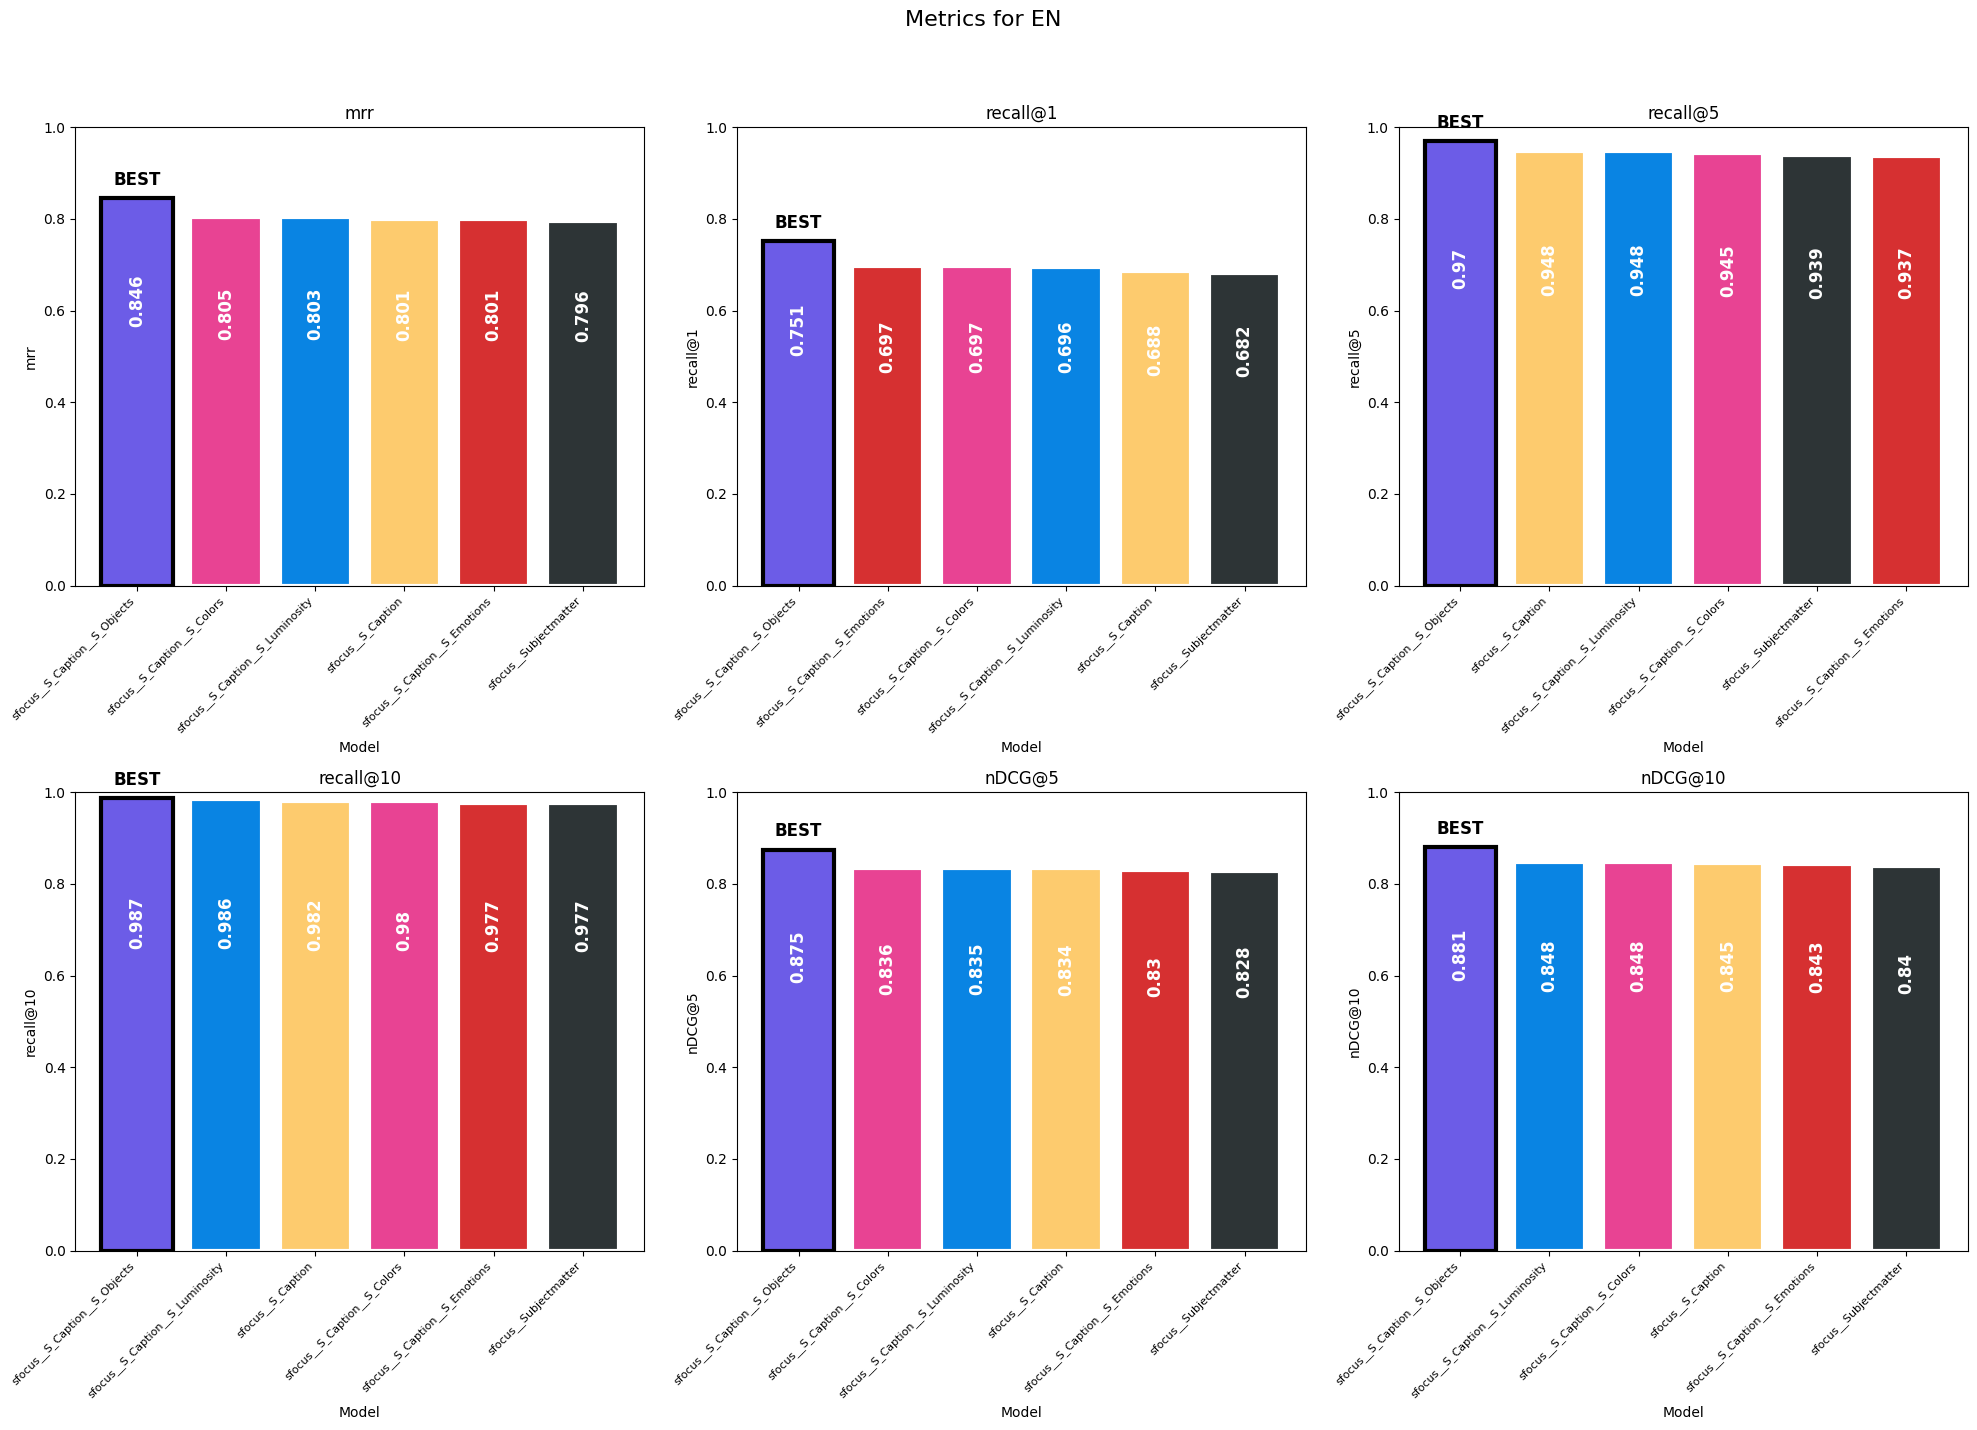

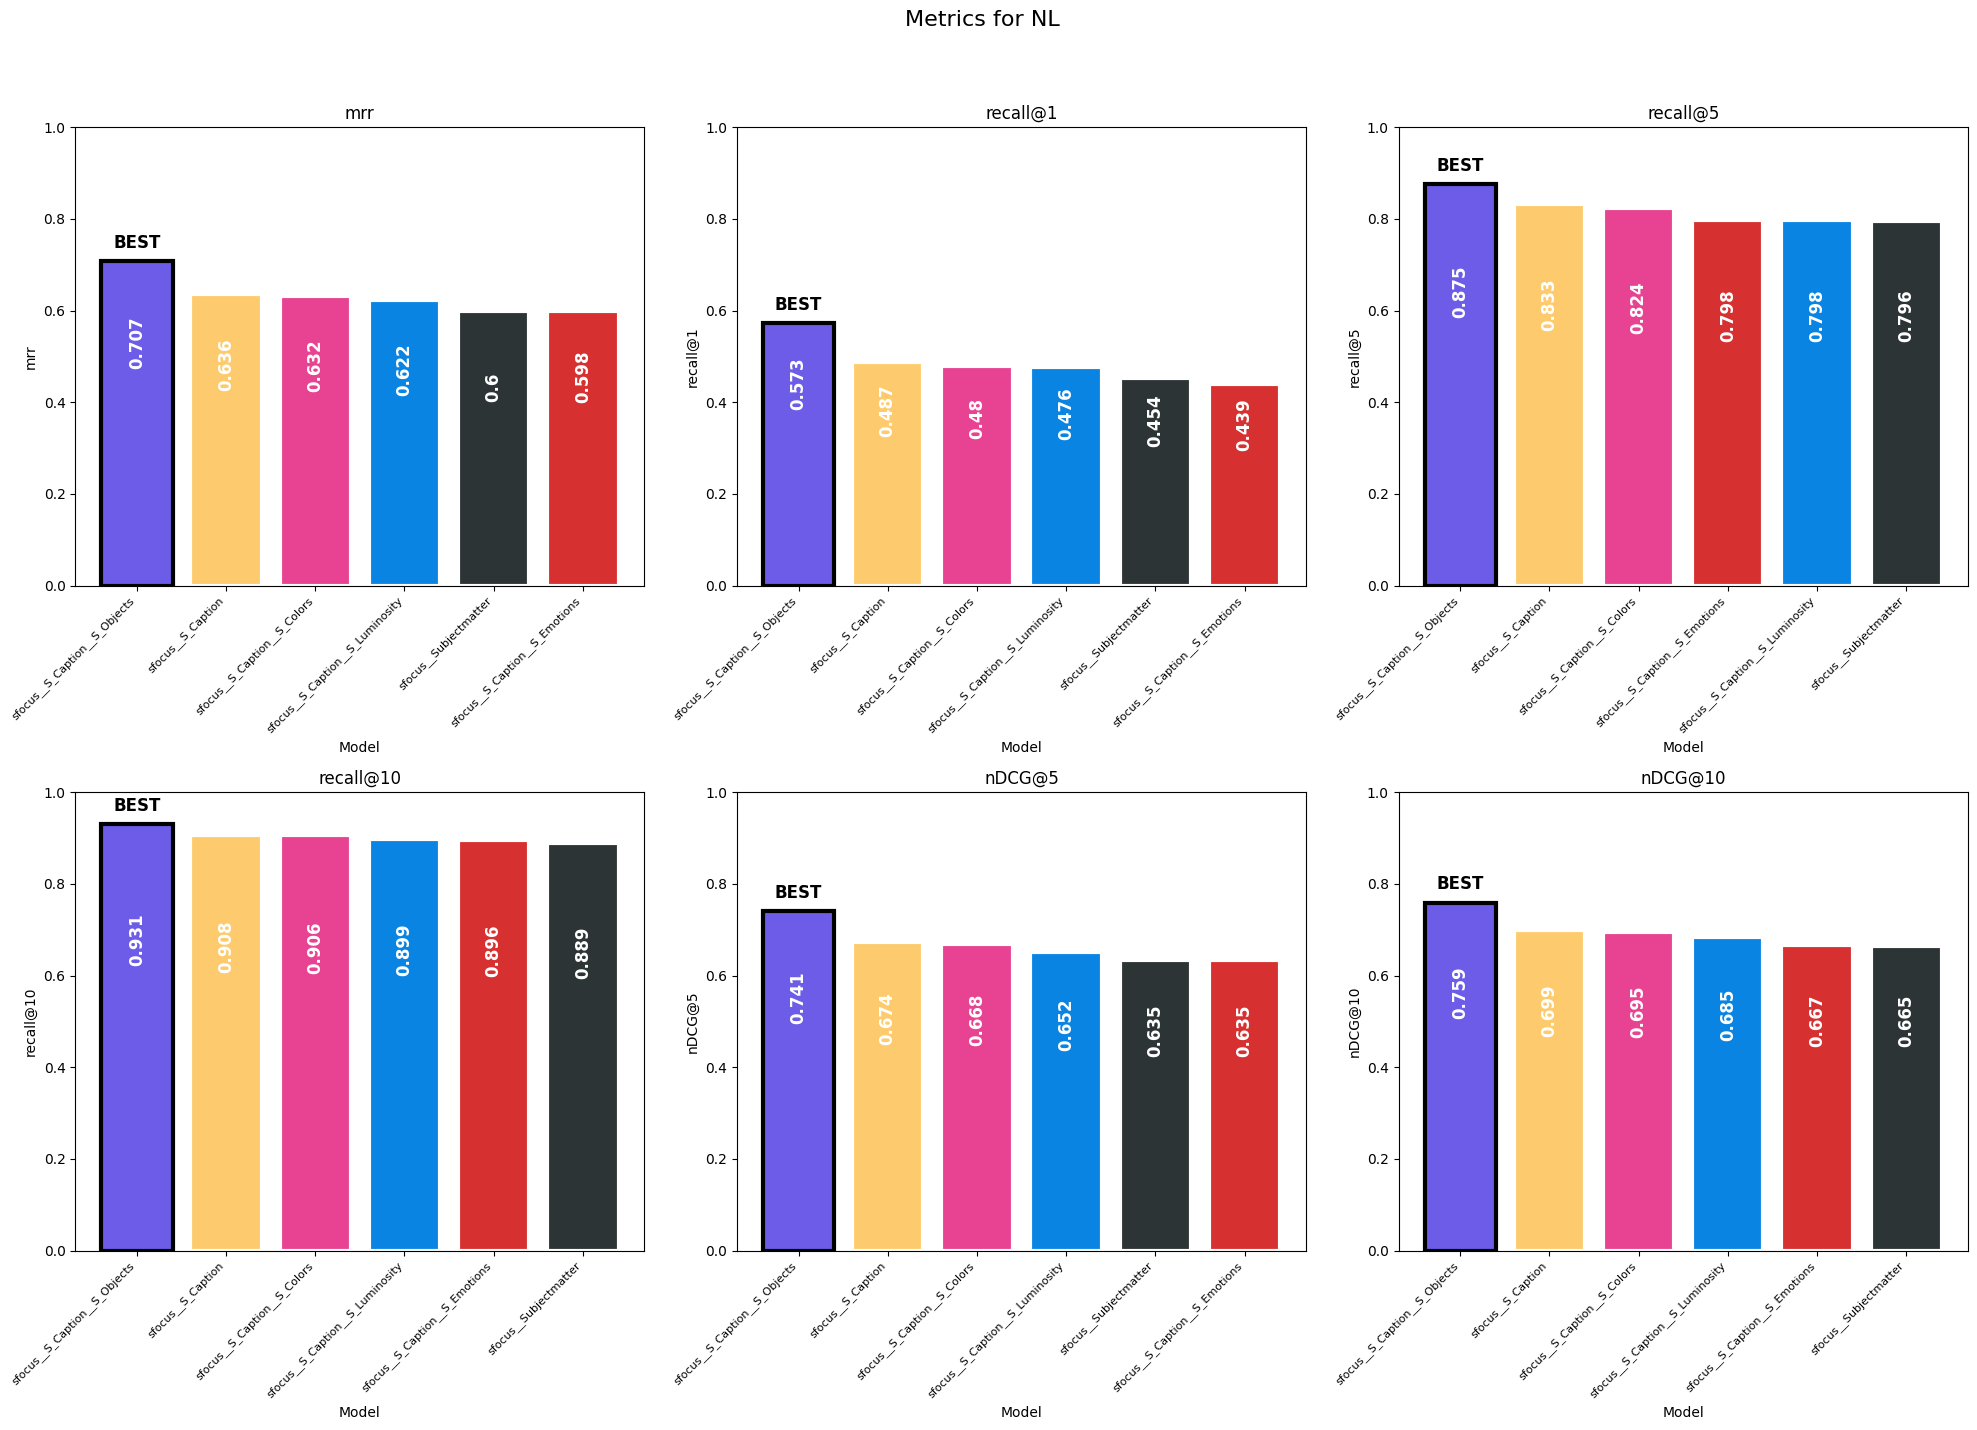

In [41]:
def plot_metrics_per_model_per_lang(lang):
    metrics = [
        "mrr",
        "recall@1",
        "recall@5",
        "recall@10",
        "nDCG@5",
        "nDCG@10"
    ]
    # 6 subplots, 1 row, 6 columns
    fig, axs = plt.subplots(2, 3, figsize=(20, 15))  

    fig.suptitle(f"Metrics for {lang}", fontsize=16)

    # Iterate over the metrics and models
    for i, metric in enumerate(metrics):
        ax = axs[i // 3, i % 3] 
        bar_width = 0.8
        bar_positions = range(len(models_name))

        bar_values = []
        for j, model_name in enumerate(models_name):
            df = all_focus_df[(all_focus_df["lang"] == lang) & (all_focus_df["model_name"] == model_name)]
            if not df.empty:
                bar_values.append(df[metric].values[0])
            else:
                bar_values.append(0)
        
        # Order bar_values
        sorted_indexes = np.argsort(bar_values)[::-1]
        bar_values = np.array(bar_values)[sorted_indexes]
        #bar_positions = np.array(bar_positions)[sorted_indexes]
        # Order colors
        local_colors = np.array(colors)[sorted_indexes]
        # Order models_name
        local_models_name = np.array(models_name)[sorted_indexes]
        
        best_value_index = np.argmax(bar_values)
        # Highlight the best value in the bar chart
        edge_colors = ["#ffffff"] * len(bar_values)
        edge_colors[best_value_index] = "#000"

        ax.bar(bar_positions, bar_values, width=bar_width, alpha=1.0, color=local_colors, label=metric, edgecolor=edge_colors, linewidth=3)
        # Add the value in the center (middle vertical) of the bar
        for j, value in enumerate(bar_values):
            ax.text(bar_positions[j], value/1.5, str(round(value, 3)), ha='center', va='bottom', fontsize=12, color='white', rotation=90, fontweight='bold')
        # Add a "BEST" label on the best bar
        ax.text(bar_positions[best_value_index], bar_values[best_value_index] + 0.02, "BEST", ha='center', va='bottom', fontsize=12, color='black', fontweight='bold')
        ax.set_title(metric, fontsize=12)
        ax.set_xlabel("Model", fontsize=10)
        ax.set_ylabel(metric, fontsize=10)
        ax.set_xticks(bar_positions)
        ax.set_xticklabels(local_models_name, rotation=45, ha="right", fontsize=8)
        ax.set_ylim(0, 1)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(f"../../figures/metrics_{lang}_sfocus.pdf", dpi=300, bbox_inches='tight')

    plt.show()

for lang in ["FR", "EN", "NL"]:
    plot_metrics_per_model_per_lang(lang)

In [42]:
dataframes_per_model = {}
for model_name in models_name:
    dataframes_per_model[model_name] = {}
    metrics = data[model_name]["metrics"]
    unique_focus = metrics["focus"].unique()
    for focus in unique_focus:
        dataframes_per_model[model_name][focus] = getdf(model_name, focus)

C:\Users\victo\AppData\Local\Temp\ipykernel_1672\4104679395.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["model_name"] = model_name


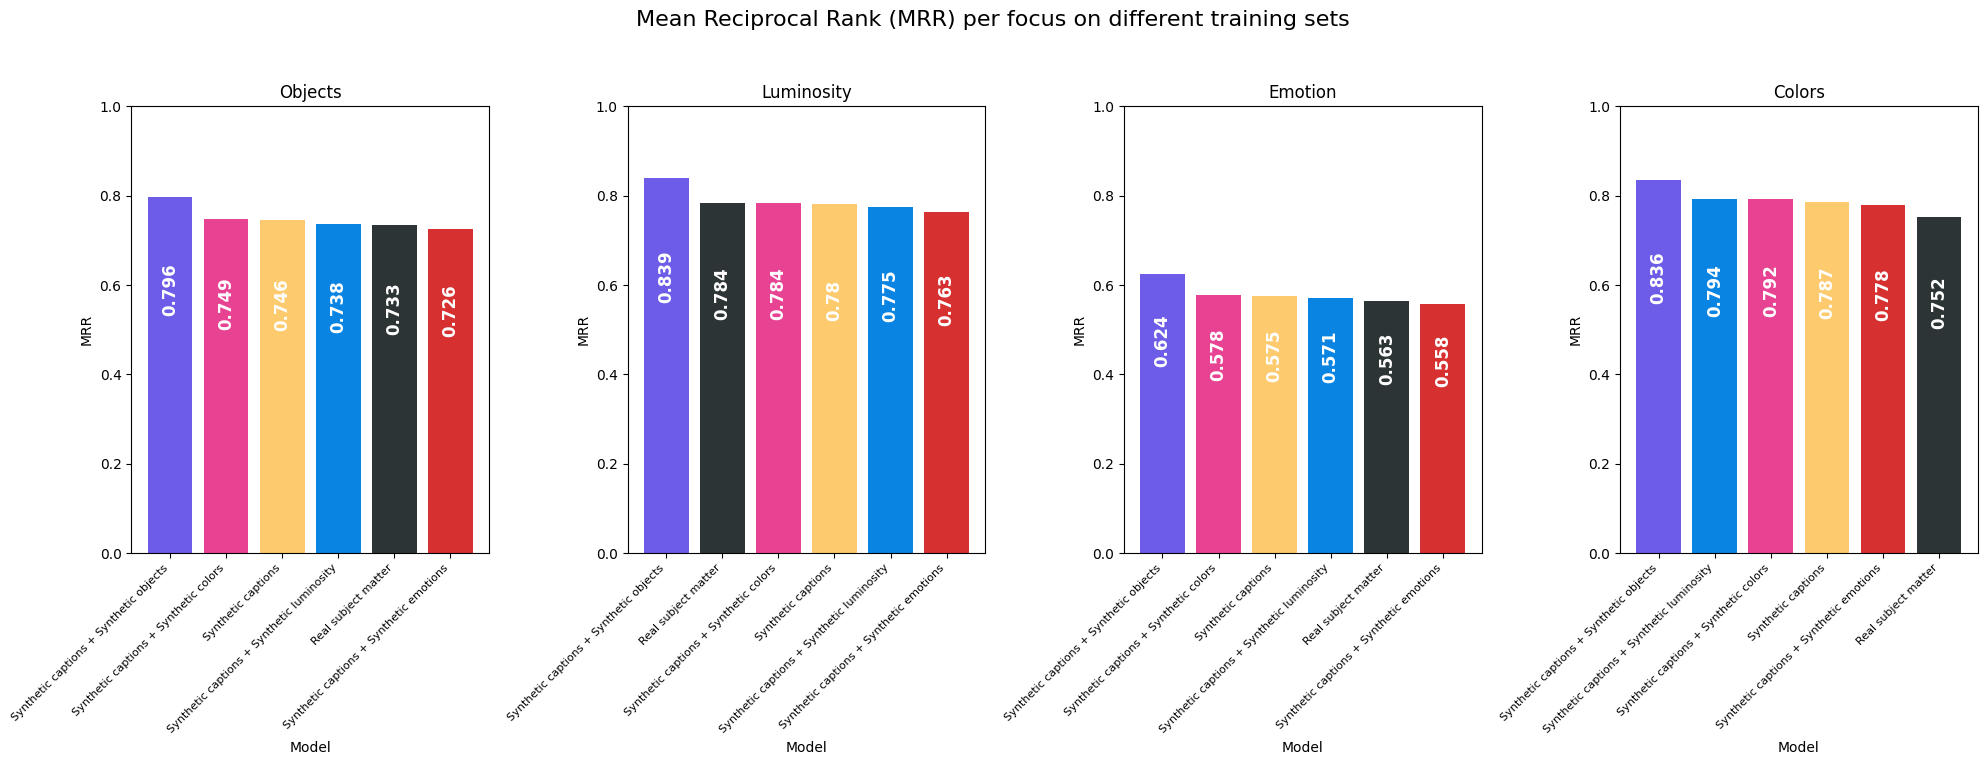

In [43]:
readable_models_name = {
    "sfocus__S_Caption": "Synthetic captions",
    "sfocus__S_Caption__S_Colors": "Synthetic captions + Synthetic colors",
    "sfocus__S_Caption__S_Emotions": "Synthetic captions + Synthetic emotions",
    "sfocus__S_Caption__S_Luminosity": "Synthetic captions + Synthetic luminosity",
    "sfocus__S_Caption__S_Objects": "Synthetic captions + Synthetic objects",
    "sfocus__Subjectmatter": "Real subject matter"
}

readable_focus = {
    "content": "Objects",
    "luminosity": "Luminosity",
    "emotion": "Emotion",
    "colors": "Colors",
}

def plot_mrr_per_focus():
    fig, axs = plt.subplots(1, 4, figsize=(20, 8))
    fig.suptitle("Mean Reciprocal Rank (MRR) per focus on different training sets", fontsize=16)
    
    axs = axs.flatten()
    for ax_index, focus in enumerate(["content", "luminosity", "emotion", "colors"]):
        bar_positions = range(len(models_name))
        bar_values = []
        bar_colors = colors
        bar_labels = []
        for model_name in models_name:
            df = dataframes_per_model[model_name][focus]

            bar_values.append(np.mean(df["mrr"].values))
            bar_labels.append(readable_models_name[model_name])

        # Order bar_values
        sorted_indexes = np.argsort(bar_values)[::-1]
        bar_values = np.array(bar_values)[sorted_indexes]
        #bar_positions = np.array(bar_positions)[sorted_indexes]
        bar_colors = np.array(bar_colors)[sorted_indexes]
        bar_labels = np.array(bar_labels)[sorted_indexes]

        ax = axs[ax_index]

        ax.bar(bar_positions, bar_values, width=0.8, alpha=1.0, color=bar_colors, label=focus)
        
        # Add the value in the center (middle vertical) of the bar
        for j, value in enumerate(bar_values):
            ax.text(bar_positions[j], value/1.5, str(round(value, 3)), ha='center', va='bottom', fontsize=12, color='white', rotation=90, fontweight='bold')

        ax.set_title(readable_focus[focus], fontsize=12)
        ax.set_xlabel("Model", fontsize=10)
        ax.set_ylabel("MRR", fontsize=10)
        ax.set_xticks(bar_positions)
        ax.set_xticklabels(bar_labels, rotation=45, ha="right", fontsize=8)
        ax.set_ylim(0, 1)


    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


plot_mrr_per_focus()

In [44]:
emoji_models_name = {
    "sfocus__S_Caption": "📜",
    "sfocus__S_Caption__S_Colors": "📜 + 🌈",
    "sfocus__S_Caption__S_Emotions": "📜 + 😢",
    "sfocus__S_Caption__S_Luminosity": "📜 + 💡",
    "sfocus__S_Caption__S_Objects": "📜 + 🐶",
    "sfocus__Subjectmatter": "🖼️",
}


def get_measures_1d():
    res = pd.DataFrame(columns=["focus"] + list(emoji_models_name.values()))
    for ax_index, focus in enumerate(["content", "luminosity", "emotion", "colors"]):
        
        values = {}

        for model_name in models_name:
            df = dataframes_per_model[model_name][focus]

            mean_mrr = np.mean(df["mrr"].values)
            values[emoji_models_name[model_name]] = mean_mrr   

        res.loc[len(res)] = [readable_focus[focus]] + list(values.values())

    return res

get_measures_1d()

,focus,📜,📜 + 🌈,📜 + 😢,📜 + 💡,📜 + 🐶,🖼️
0,Objects,0.746399,0.748694,0.725586,0.737541,0.796109,0.733286
1,Luminosity,0.780391,0.783806,0.763302,0.774681,0.839430,0.784083
2,Emotion,0.575225,0.578329,0.557583,0.571281,0.623715,0.563186
3,Colors,0.786940,0.792221,0.778434,0.793661,0.835742,0.752149


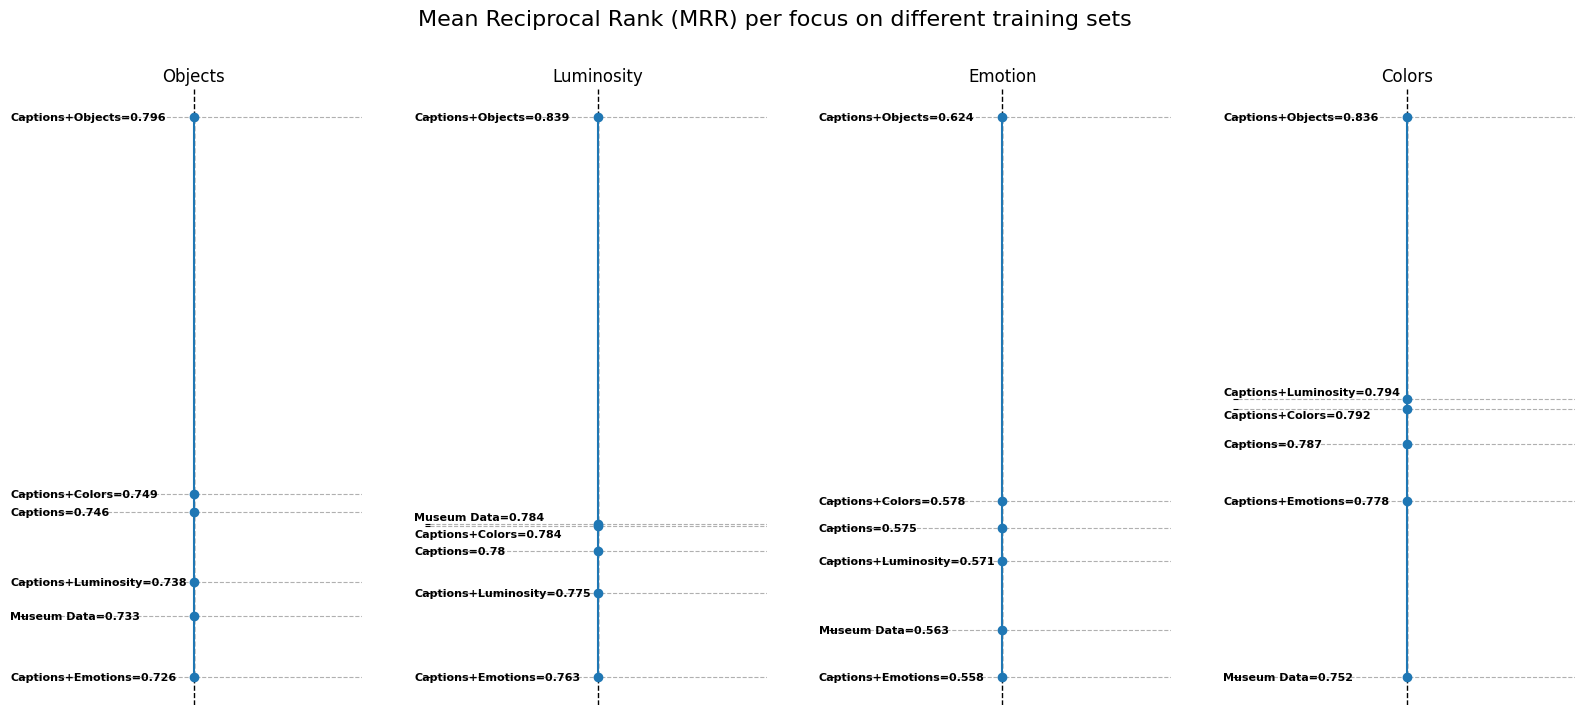

In [49]:
quick_models_name = {
    "sfocus__S_Caption": "Captions",
    "sfocus__S_Caption__S_Colors": "Captions+Colors",
    "sfocus__S_Caption__S_Emotions": "Captions+Emotions",
    "sfocus__S_Caption__S_Luminosity": "Captions+Luminosity",
    "sfocus__S_Caption__S_Objects": "Captions+Objects",
    "sfocus__Subjectmatter": "Museum Data"
}


def plot_1d_lines():
    fig, axs = plt.subplots(1, 4, figsize=(20, 8))
    fig.suptitle("Mean Reciprocal Rank (MRR) per focus on different training sets", fontsize=16)
    
    values = {}
    min_value = float("inf")
    max_value = float("-inf")

    for ax_index, focus in enumerate(["content", "luminosity", "emotion", "colors"]):
        
        values[ax_index] = {}

        for model_name in models_name:
            df = dataframes_per_model[model_name][focus]

            mean_mrr = np.mean(df["mrr"].values)
            values[ax_index][quick_models_name[model_name]] = mean_mrr   

            min_value = min(min_value, mean_mrr)
            max_value = max(max_value, mean_mrr)


    # Plot
    for ax_index, focus in enumerate(["content", "luminosity", "emotion", "colors"]):

        values_focus = values[ax_index]

        # Plot on a 1D line
        ax = axs[ax_index]
        
        ticks = []
        y_labels = []
        for label in values_focus.keys():
            ticks.append(values_focus[label])
            y_labels.append(label)

        ticks = np.array(ticks)
        sorted_indexes = np.argsort(ticks)
        ticks = np.array(ticks)[sorted_indexes]
        y_labels = np.array(y_labels)[sorted_indexes]

        pos_y = []
        for i in range(len(ticks)):
            tick_value = ticks[i]
            pos_y.append(tick_value)

        pos_y = sorted(pos_y)
        pos_y_corrected = []
        i = 0
        p = 0.001
        while i < len(pos_y) - 1:
            pos_y_1 = pos_y[i]
            pos_y_2 = pos_y[i + 1]
            dist = pos_y_2 - pos_y_1
            if dist < 0.002:
                pos_y_corrected.append(pos_y_1-p)
                pos_y_corrected.append(pos_y_2+p)
                i += 2
            else:
                pos_y_corrected.append(pos_y_1)
                i += 1

        if len(pos_y_corrected) < len(ticks):
            pos_y_corrected.append(pos_y[-1])

        # Add a vertical line 
        ax.axvline(x=0, color='black', linestyle='--', linewidth=1)


        ax.plot(np.zeros(len(values_focus)), ticks, marker='o')
        ax.set_yticks(ticks)
        ax.set_yticklabels([""] * len(values_focus), fontsize=10, fontweight='bold')
        # Add the labels above the line
        for i, label in enumerate(y_labels):
            value = str(round(ticks[i], 3))
            # Add a white box behind the text
            ax.text(-0.06, pos_y_corrected[i], label + "=" + value, fontsize=8, ha='left', va='center', fontweight='bold')#, bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.3'))

        ax.set_xticks([])
        # Disable axis
        for f in ax.spines:
            ax.spines[f].set_visible(False)

        ax.grid(True, linestyle='--', alpha=1.0)

        min_y = np.amin(pos_y_corrected)*0.99
        max_y = np.amax(pos_y_corrected)*1.01
        #ax.set_ylim(min_y, max_y)

        ax.set_title(readable_focus[focus], fontsize=12)

    plt.show()

plot_1d_lines()